In [122]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
from utils import *

In [123]:
def transform_Z_to_X(Z):
    """
    Transforms a tensor Z of shape (n_mc, n, 4) into X using non-linear transformations.
    Works with both 2D (n, 4) and 3D (n_mc, n, 4) inputs.
    """
    if Z.shape[-1] != 4:
        raise ValueError("Z must have 4 columns in the last dimension")

    # Extract dimensions
    Z1, Z2, Z3, Z4 = Z[..., 0], Z[..., 1], Z[..., 2], Z[..., 3]

    # Apply transformations (vectorized)
    X1 = np.sin(Z2 * 4) + np.log1p(np.abs(Z3)) - Z4**2 + 0.5 * Z1
    X2 = Z2
    X3 = Z3
    X4 = Z4

    # Stack along last axis
    X = np.stack((X1, X2, X3, X4), axis=-1)

    return X


def generate_X(n, d, corr_rate=0):
    mu = np.zeros(d)
    cov = toep(d,  corr_rate)

    Z = np.random.multivariate_normal(mu, cov, size=n)

    X = transform_Z_to_X(Z)

    return X, Z


In [124]:
import numpy as np
import scipy.stats as stats


def get_y_prob_bayes(Z, full_mu, full_cov, true_beta, n_mc=1000, intercept=0):

    # 1. Make MCMC samples from conditional distribution of Z_mis | Z_obs
    M = np.isnan(X)
    unique_patterns = np.unique(M, axis=0)
    
    Z_FULL = np.zeros((n_mc, Z.shape[0], Z.shape[1]))
    for pattern in unique_patterns:
            
        row_pattern = np.all(M == pattern, axis=1)

        Z_m = Z[row_pattern]

        if np.sum(pattern) == 0:
            
            Z_FULL[:, row_pattern, :] = Z_m
            continue

        m = np.isnan(Z_m[0])
        observed_idx = ~m
        missing_idx = m

        mu_obs = full_mu[observed_idx]
        mu_mis = full_mu[missing_idx]

        cov_obs = full_cov[np.ix_(observed_idx, observed_idx)]
        cov_obs_inv = np.linalg.inv(cov_obs)

        cov_mis = full_cov[np.ix_(missing_idx, missing_idx)]
        cross_cov = full_cov[np.ix_(observed_idx, missing_idx)]

        cond_cov = cov_mis - cross_cov.T @ cov_obs_inv @ cross_cov

        z_full_pattern = np.zeros((n_mc, Z_m.shape[0], Z_m.shape[1]))

        for i in range(Z_m.shape[0]):
            
            z_obs = Z_m[i, observed_idx]
            cond_mu = mu_mis + cross_cov.T @ cov_obs_inv @ (z_obs - mu_obs)

            if len(cond_mu) == 0:
                Z_mc = np.zeros((n_mc, 0)).ravel()
            else:
                Z_mc = np.random.multivariate_normal(cond_mu, cond_cov, size=n_mc).ravel()

            z_full = np.zeros((n_mc, d))
            z_full[:, observed_idx] = np.tile(z_obs, (n_mc, 1))
            z_full[:, missing_idx] = Z_mc.reshape(n_mc, -1)
        
            z_full_pattern[:,i,:] = z_full
        
        Z_FULL[:, row_pattern, :] = z_full_pattern


    # 2. Compute X_full from Z_full
    X_FULL = transform_Z_to_X(Z_FULL)


    # 3. Compute y_probs from X_full
    y_logits = np.dot(X_FULL, true_beta) + intercept
    y_probs = sigma(y_logits)


    return y_probs




# --- Running the pipeline ---
n = 10000
cov = 0.9
d = 4

X_full, Z_full = generate_X(n, d, corr_rate=cov)

M = generate_mask(n, d, 0.35)
X = X_full.copy()
X[M==1] = np.nan
Z = Z_full.copy()
Z[M==1] = np.nan

beta = np.random.normal(0, 1, size=4)
y_logits = np.dot(X_full, beta)
y_probs = sigma(y_logits)
y = np.random.binomial(1, y_probs)


mu = np.zeros(d)
cov_matrix = toep(d, cov)


y_probs_bayes = get_y_prob_bayes(Z, mu, cov_matrix, beta, n_mc=100, intercept=0).mean(axis=0)


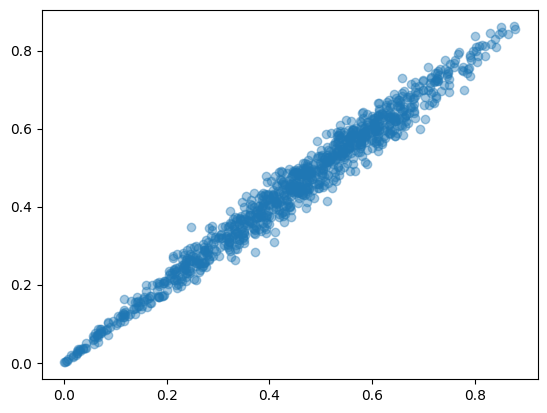

In [125]:
idx = get_index_pattern([1,0], M)
plt.scatter(y_probs[idx], y_probs_bayes[idx], alpha=0.4);

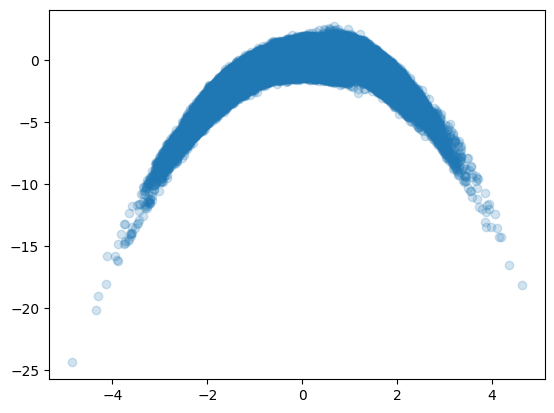

In [130]:
plt.scatter(X_full[:,3], X_full[:,0], alpha=0.2);

In [127]:
# Define the percentages of missingness and number of replicates

experiment_name = "ExpD"
experiment_data_folder = os.path.join("data", experiment_name)

if os.path.exists(experiment_data_folder) == False:
    os.makedirs(experiment_data_folder)

if os.path.exists(os.path.join(experiment_data_folder, "original_data")) == False:
    os.makedirs(os.path.join(experiment_data_folder, "original_data"))

if os.path.exists(os.path.join(experiment_data_folder, "test_data")) == False:
    os.makedirs(os.path.join(experiment_data_folder, "test_data"))

if os.path.exists(os.path.join(experiment_data_folder, "pred_data")) == False:
    os.makedirs(os.path.join(experiment_data_folder, "pred_data"))

if os.path.exists(os.path.join(experiment_data_folder, "bayes_data")) == False:
    os.makedirs(os.path.join(experiment_data_folder, "bayes_data"))


missingness_percentages = [0.35]
n_replicates = 2
Ds = [4]
Corrs = [0., 0.65, 0.95]
n_train = 100000
n_test = 15000
n = n_train + n_test

print("# of setups = ", n_replicates * len(missingness_percentages) * len(Corrs))

N_MC = 5000

# The set-up dataframe should contain:
# - rep
# - n
# - trueProp1
# - true_beta
# - center_X
# - set_up (name)
# [The rest will be part of **kwargs throughout the code]

df_set_up = pd.DataFrame({
    "rep":[],
    "n":[],
    "true_beta": [],
    "set_up": [],
    "d":[],
    "corr":[],
    "prcNA": [],
}).T

np.random.seed(1)
random.seed(1)

for rep in range(n_replicates):
    print("REP", rep)
    for d in Ds:

        beta0 = np.random.normal(0, 1.0, d)

        for corr in Corrs:

            corr_str = str(corr).replace(".", "")
                
            X_full, Z_full = generate_X(n, d, corr_rate=corr)
            y_probs = sigma(X_full @ beta0)
            y = np.random.binomial(n=1, p=y_probs)
            
            for prc in missingness_percentages:

                prc_str = str(prc).replace(".", "")
                set_up = f"LOG_n{n}_d{d}_corr{corr_str}_prcNA{prc_str}_rep{rep}"

                M = generate_mask(n, d, prc) # don't allow fully missing
                
                X_obs = X_full.copy()
                X_obs[M == 1] = np.nan


                new_row = pd.Series({
                    "rep":rep,
                    "n":n,
                    "d":d,
                    "corr":corr,
                    "prcNA":prc,
                    "true_beta":beta0,
                    "set_up":set_up
                })

                df_set_up = pd.concat([df_set_up, new_row], axis=1, ignore_index=True)

                data_to_save = {
                    "X_obs": X_obs,
                    "M": M,
                    "y": y,
                    "y_probs": y_probs,
                    "X_full": X_full
                }

                # save
                np.savez(os.path.join(experiment_data_folder, "original_data", f"{set_up}.npz"), **data_to_save)

                # test data
                X_test = X_obs[n_train:]
                y_test = y[n_train:]
                y_probs_test = y_probs[n_train:]
                M_test = M[n_train:]
                data_to_save_test = {
                    "X_obs": X_test,
                    "M": M_test,
                    "y": y_test,
                    "y_probs": y_probs_test,
                    "X_full": X_full[n_train:]
                }
                np.savez(os.path.join(experiment_data_folder, "test_data", f"{set_up}.npz"), **data_to_save_test)

                # bayes
                full_mu = np.zeros(d)
                full_cov = toep(d, corr)
                y_probs_bayes = get_y_prob_bayes(Z, full_mu, full_cov, beta0, n_mc=N_MC, intercept=0)
                y_probs_bayes = y_probs_bayes.mean(axis=1)

                data_to_save_bayes = {
                    "y_probs_bayes": y_probs_bayes
                }

                np.savez(os.path.join(experiment_data_folder, "bayes_data", f"{set_up}.npz"), **data_to_save_bayes)


                    
# save df set-up
df_set_up.T.to_csv(os.path.join(experiment_data_folder, "set_up.csv"), index=False)

# of setups =  6
REP 0
REP 1
